In [1]:
import numpy as np
from numpy.random import randint

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output

/Users/joncomo/miniconda2/envs/phys/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/joncomo/miniconda2/envs/phys/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
from keras import backend as K

Using TensorFlow backend.


In [4]:
import pyglet
from pyglet import app
from pyglet.window import Window, mouse, key
from pyglet import gl

pyglet.options['audio'] = ('openal', 'pulse', 'directsound', 'silent')
from pyglet.media import procedural
sine_hi = procedural.WhiteNoise(.05)
sine_lo = procedural.Sine(.2, frequency=300)

In [5]:
class Env(object):
    def __init__(self, r, c):
        self.r = r
        self.c = c
        self.screen = np.zeros((r, c))
        self.state = {}
        self.reset()
        
    def reset(self, rand_length=False):
        self.prev_states = []
        self.screen[:] = 0
        l = 3
        if rand_length:
            l = randint(3, int(self.r*self.c*1/4))
        self.state = {'p': (randint(0, self.r), randint(0, self.c)),
                      'f': (randint(0, self.r), randint(0, self.c)),
                      't': [],
                      'l': l}
        
    def step(self, state, action):
        if action is None:
            return (0, state, True)
        
        p = state['p'] # position
        f = state['f'] # food
        t = state['t'] # tail
        l = state['l'] # length
        
        reward = 0
        
        # copy tail
        t = [coord for coord in t]
        t.insert(0, p)
        if len(t) > l:
            t.pop()
            
        newp = self.move(p, action)
        newf = [f[0], f[1]]
        
        if newp == f:
            # got food
            reward = 1
            l += 1
            newf = [randint(0, self.r), randint(0, self.c)]
        
        end = False   
        if self.out_of_bounds(newp) or newp in t:
            reward = 0
            end = True
            
        new_state = {'p': newp,
                     'f': newf,
                     't': t,
                     'l': l}
        
        return reward, new_state, end
    
    def move(self, p, action):
        newp = None
        if action == 0: #up
            newp = [p[0]-1, p[1]]
        elif action == 1: #down
            newp = [p[0]+1, p[1]]
        elif action == 2: #left
            newp = [p[0], p[1]-1]
        elif action == 3: #right
            newp = [p[0], p[1]+1]
        return newp
    
    def out_of_bounds(self, p):
        return p[0] < 0 or p[0] > self.r-1 or p[1] < 0 or p[1] > self.c-1
    
    def random_action(self, state):
        p = state['p']
        t = state['t']
        possible = []
        for action in range(4):
            newp = self.move(p, action)
            if not self.out_of_bounds(newp) and newp not in t:
                possible.append(action)
        if len(possible) == 0:
            return None
        
        return np.random.choice(possible)
    
    def stack(self, states):
        stack = np.zeros((1, env.r, env.c, len(states)))
        
        for i in range(len(states)):
            s = states[i]
            stack[:,:,:,i] = env.render(s)
            
        return stack
    
    def step_model(self, model):
        
        reward, state, end = None, None, None
        action = None
        
        while(len(self.prev_states) < TIME_STEPS-1):
            reward, state, end = self.step(self.state, self.random_action(self.state))
            self.state = state
            self.prev_states.append(state)
        
        max_v = -1000000000
        runner_up = None
        for pot_action in [0, 1, 2, 3]:
            reward, pot_state, pot_end = self.step(self.state, pot_action)
            if pot_end:
                continue
                
            stack = self.stack(self.prev_states + [pot_state])
            
            test_v = model.predict(stack)[0, 0]
            test_v += reward
            if test_v > max_v:
                max_v = test_v
                action = pot_action

        if action is None: # there were no good future states, reset
            self.reset()
            reward, state, end = -1, env.state, True
        else:
            reward, state, end = self.step(self.state, action)
            
        self.state = state
        self.prev_states.append(state)
        self.prev_states = self.prev_states[1:]
        
        return reward, state, end
    
    def render(self, state, alpha_mode=False):
        p = state['p']
        f = state['f']
        t = state['t']
        
        self.screen[:] = 0
        self.screen[p[0], p[1]] = 1
        self.screen[f[0], f[1]] = 1
        
        # render tail
        if alpha_mode:
            alpha = 1
            diff = 0
            if len(t) > 0:
                diff = 1.0/len(t)
            for coord in t:
                self.screen[coord[0], coord[1]] = alpha
                alpha -= diff
        else:
            for coord in t:
                self.screen[coord[0], coord[1]] = 1
        
        return self.screen

In [6]:
env = Env(10, 10)

In [7]:
history = []

In [8]:
# gather some session history

i = 0
while len(history) < 10000:
    i += 1
    if (i+1) % 5000 == 0:
        print(len(history))
        
    env.reset(rand_length=True)
    end = False
    steps = 0
    session = []
    non_zero_reward = False
    
    while not end:
        state = env.state
        action = env.random_action(state)
        reward, new_state, end = env.step(env.state, action)
        
        # decay the reward back
        if reward != 0:
            non_zero_reward = True
            decay = reward
            for sar in reversed(session):
                sar[2] += decay
                decay *= 0.6
        
        sar = [state, action, reward]
        session.append(sar)
        
        steps += 1
        
        if end or steps > 30:
            break
        
        env.state = new_state
    
    if non_zero_reward:
        history.append(session)

1186
2361
3537
4729
5933
7145
8340
9529


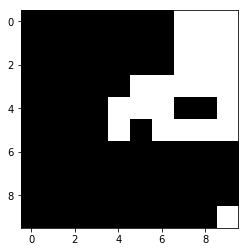

reward: 0


In [106]:
def play_session(session):
    for sar in session:
        screen = env.render(sar[0], alpha_mode=False)
        
        clear_output(wait=True)
        fig = plt.imshow(screen, interpolation='nearest', cmap=plt.cm.gray)
        plt.show()
        print('reward: {}'.format(sar[2]))
        
# most food session

best_s = None
max_r = 0

for session in history:
    r = 0
    for sar in session:
        r += sar[2]
        if r > max_r:
            max_r = r
            best_s = session
            
play_session(best_s)

In [9]:
# time steps per session
TIME_STEPS = 2

input_shape = None
if K.image_data_format() == 'channels_first':
    input_shape = (TIME_STEPS, env.r, env.c)
else:
    input_shape = (env.r, env.c, TIME_STEPS)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.20))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.mse,
      optimizer=keras.optimizers.Adadelta(lr=1),
      metrics=['accuracy'])

In [10]:
# train the model, predict reward given state

x_train = []
y_train = []

i = 0
while len(x_train) < 100000:
    i += 1
    if (i+1) % 10000 == 0:
        print(len(x_train))
        
    random_session = history[randint(len(history))]
    ri = randint(0, len(random_session)-TIME_STEPS)
    
    sars = [random_session[ri + t] for t in range(TIME_STEPS)]
    states = [sar[0] for sar in sars]
    state = env.stack(states)
    reward = sars[-1][2] # reward for state
    
    
    x_train.append(state)
    y_train.append(reward)
    
    #r = np.random.random_sample()
    
    #if r < .33:
    #    x_train.append(state)
    #elif r >= .33 and r < .66:
    #    x_train.append(np.fliplr(state))
    #else:
    #    x_train.append(np.flipud(state))

9998
19998
29998
39998
49998
59998
69998
79998
89998
99998


Epoch 1/1
100000/100000 [==============================] - 18s 180us/step - loss: 0.0887 - acc: 0.4347


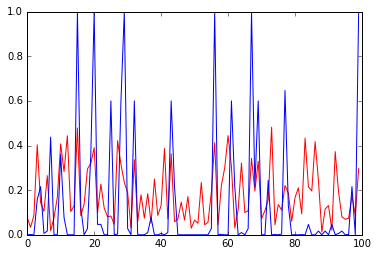

In [11]:
model.fit(np.vstack(x_train), np.vstack(y_train), batch_size=64, epochs=1)

fig = plt.plot(model.predict(np.vstack(x_train)[:100]), c='r')
fig = plt.plot(np.vstack(y_train)[:100], c='b')

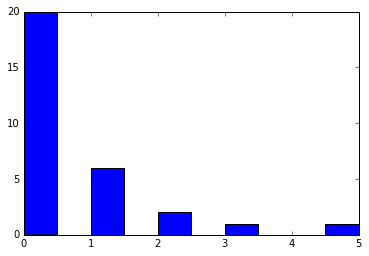

In [12]:
# get an idea of distribution of rewards

rs = []

for i in range(30):
    env.reset()
    end = False
    total_r = 0
    for j in range(50): # j steps
        r, s, end = env.step_model(model)
        total_r += r
        if end:
            break
        
    rs.append(total_r)
        
fig = plt.hist(rs)

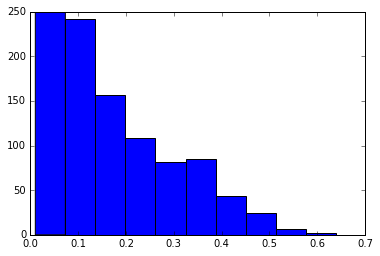

In [13]:
# get an idea of model predictions for random states

vs = []
for i in range(1000):
    random_session = history[randint(len(history))]
    ri = randint(0, len(random_session)-TIME_STEPS-1)
    
    sars = [random_session[ri + t] for t in range(TIME_STEPS)]
    states = [sar[0] for sar in sars]
    state = env.stack(states)

    v = model.predict(state)[0, 0]
    vs.append(v)
        
fig = plt.hist(vs)

In [15]:
# visualize pyglet

bw, bh = 10, 10
win_width, win_height = bw*env.c, bh*env.r

# create window and run display it
win = Window(width=win_width, height=win_height)

def on_mouse_press(x, y, button, modifiers):
    env.reset()
    
win.push_handlers(on_mouse_press)

def draw_rect(x, y, w, h, color):
    pyglet.graphics.draw(6, gl.GL_TRIANGLES,
                    ('v2f', [x, y, 
                             x+w, y,
                             x+w, y+h, 
                             x, y, 
                             x, y+h, 
                             x+w, y+h]),
                    ('c4f', color * 6))

if 'loop' in globals():
    pyglet.clock.unschedule(loop)

prev_s = None
vs = []
def loop(e):
    global env, model, prev_s, vs
    
    r, s, e = env.step_model(model)
    
    if r == 1:
        sine_hi.seek(0)
        sine_hi.play()
    elif e:
        sine_lo.seek(0)
        sine_lo.play()
        
    clear_output(wait=True)
    if prev_s is not None:
        v = model.predict(env.stack([prev_s, s]))[0, 0]
        #vs.append(v)
        #fig = plt.plot(vs)
        #plt.show()
        print(v)
    prev_s = s

def on_draw():
    global env
    
    win.clear()
    
    screen = env.render(env.state)
    for index, x in np.ndenumerate(screen):
        if x != 0:
            # draw a rect
            c = [1,1,1,1]

            draw_rect(index[0]*bw, index[1]*bh, bw, bh, c)

env.reset()            
win.on_draw = on_draw
pyglet.clock.schedule(loop)
pyglet.app.run()
win.close()

0.145619


In [ ]:
# visualize matplotlib

env.reset()
for i in range(100):
    env.step_model(model)
    screen = env.render(env.state)
    
    clear_output(wait=True)
    fig = plt.imshow(screen, interpolation='nearest', cmap=plt.cm.gray)
    plt.show()